In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from keras import layers
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
path = "./data/"
filename_read = os.path.join(path, "housing.csv")
filename_write = os.path.join(path, "housing-out.csv")
df = pd.read_csv(filename_read, na_values=['NA', '?'])


In [3]:
# replace the values yes or no with 0 and 1
cols_yes_no = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
for col in cols_yes_no:
    df[col] = df[col].map({"yes":1, "no":0})


In [ ]:

The furnishingstatus column has three values: furnished, semi-furnished and 
unfurnished. If we encode them with 3 different values (for example 0, 1, 2), 
the network will consider that there is a numerical order like "small-medium-large", 
although in reality there is no logical order between these values. 
Therefore, we will use the One Hot Encoding (OHE) method, which transforms 
each separate category into a column with 0 and 1. This way all categories 
are treated equally. In our case, we will remove the first column (drop_first=True) 
to avoid redundancy (if both created columns - furnishingstatus_semi-furnished 
and furnishingstatus_unfurnished - will have the value 0, then it means
that the house is furnished)
So to differentiate between 3 categories, two values are enough.
    

In [5]:

#if 'furnishingstatus' in df.columns:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=False)

# because the resulting columns are of type bool, we convert them to int
bool_cols = ['furnishingstatus_furnished', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']
df[bool_cols] = df[bool_cols].astype(int)


In [6]:
# Schuffle the dataset
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

dataset = df.values

In [7]:
x = dataset[:,1:15]
y = dataset[:,0]

# Cross-Validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0

# KFold.split(x) returns indices, that is the rows in the dataset that are part of the train and test for the current fold
for train_idx, test_idx in kf.split(x):  #train_idx and test_idx are lists of indices (for clarity I put idx at the end)
    fold+=1
    print("Fold #{}".format(fold))

    # Split in train/test
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # ==SCALE DATA==
    scaler_x = StandardScaler()
    x_train_scaled = scaler_x.fit_transform(x_train)
    x_test_scaled = scaler_x.transform(x_test)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    # CREATE MODEL
    model = Sequential()
    model.add(layers.Input(shape=(x_train.shape[1],)))
    model.add(layers.Dense(18, activation='relu'))
    model.add(layers.Dense(22, activation='relu'))
    model.add(layers.Dense(1))     
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, mode='auto')

    # TRAIN
    model.fit(x_train_scaled,y_train_scaled,validation_data=(x_test_scaled,y_test_scaled),callbacks=[monitor],verbose=1,epochs=500)

    # PREDICT
    pred_scaled = model.predict(x_test_scaled)

    # Unscale and save results
    pred_real = scaler_y.inverse_transform(pred_scaled)
    y_real = scaler_y.inverse_transform(y_test_scaled)
    oos_y.append(y_real)
    oos_pred.append(pred_real)


    # === Measure this fold's RMSE ===
    # Scikit-learn expects both arrays to have the same shape, and pred_real is a 2D array of the shape (num_samples, 1).
    # So we make y_test a 2D array as well -> y_test.reshape(-1, 1)
    rmse_scaled = np.sqrt(metrics.mean_squared_error(pred_scaled, y_test_scaled))
    print("Fold score (RMSE, scaled): {}".format(rmse_scaled))

    score = np.sqrt(metrics.mean_squared_error(pred_real,y_real))
    print("Fold score (RMSE): {}".format(score))



# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score))



# Write the cross-validated prediction in csv
# Flatten 2D arrays into 1D arrays
oos_y_flat = np.concatenate(oos_y).flatten()
oos_pred_flat = np.concatenate(oos_pred).flatten()
# Convert to DataFrames
oos_y_df = pd.DataFrame(oos_y_flat, columns=['RealPrice'])
oos_pred_df = pd.DataFrame(oos_pred_flat, columns=["PredictedPrice"])
# Concatenate with original df
oosDF = pd.concat([df.reset_index(drop=True), oos_y_df, oos_pred_df], axis=1)
# Save to CSV
oosDF.to_csv(filename_write, index=False)


Fold #1
Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.1341 - val_loss: 1.5249
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8911 - val_loss: 1.2719
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7413 - val_loss: 1.0858
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6205 - val_loss: 0.9511
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5358 - val_loss: 0.8294
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4687 - val_loss: 0.7501
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4247 - val_loss: 0.6926
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3924 - val_loss: 0.6524
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3700 - val_loss: 0.6322
Epoch 10/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3495 - val_loss: 0.6278
Epoch 11/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3340 - val_loss: 0.6177
Epoch 12/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [8]:
# for verification, is it optional :)
r = pd.DataFrame(y_real, columns=['ActualPrice'])
r['PredictedPrice'] = pred_real
print(r[:20])

    ActualPrice  PredictedPrice
0     9870000.0      7767716.00
1     3990000.0      3484222.00
2     3850000.0      3167281.00
3     7000000.0      7545349.00
4     4200000.0      4433709.00
5     9240000.0      6231423.50
6     5523000.0      5130879.00
7     7875000.0      6409462.50
8     3633000.0      3509998.00
9     5110000.0      5688309.50
10    2100000.0      2928841.25
11    4830000.0      3977071.50
12    3430000.0      3213790.00
13    4270000.0      3757359.25
14    2730000.0      3358930.50
15    2835000.0      3068903.25
16    3920000.0      3012942.25
17    4620000.0      4515400.50
18    4900000.0      4606941.00
19    4893000.0      7502939.50


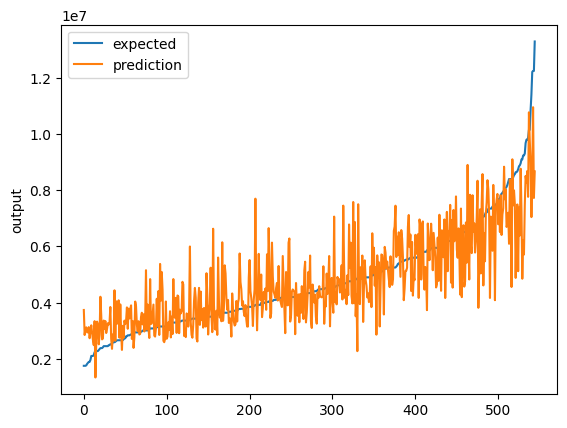

In [9]:

def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


# Plot the chart
chart_regression(oos_pred.flatten(), oos_y.flatten())